In [0]:
%tensorflow_version 2.x


In [0]:
import tensorflow as tf
import numpy as np
from PIL import Image
from IPython import display
import random
import gc
import cv2 
import numpy.matlib
SEED = 10


np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [0]:
## Due to ram issue work first on small dataSet

TRAINSIZE = 6000
TESTSIZE = 1000
TARGETSIZE = 300  # mobilenet size
CURRENTSIZE = 56   # mnist size
IMG_SHAPE = (TARGETSIZE, TARGETSIZE, 3)



In [0]:
## SSD feature layer 
listLayerWidth = [38,19,10,5,3,1]
listNumBoxes = [4,6,6,6,4,4]
numClasses = 10 + 1 #mnist 10 plus background  0-9 is digit 10 means background
LastChannel = numClasses + 4 # class and corresponding delta(cx,cy,h,w)

# **Model Creation**




In [0]:
inputTensor = tf.keras.Input(IMG_SHAPE)
mobileNet = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', input_tensor=inputTensor)
mobileNet.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
### Followed architecture of the main complete SSD architecture model , 
# We can keep lower number of channels for faster implementation

FeatureLayer = []

FeatureLayer.append(mobileNet.get_layer('block_6_expand_relu').output)
FeatureLayer.append(mobileNet.get_layer('block_13_expand_relu').output)

SSDConv1a = tf.keras.layers.Conv2D(256, 1)
SSDConv1b = tf.keras.layers.Conv2D(512, 3,strides=(2,2), padding='same')
FeatureLayer.append(SSDConv1b(SSDConv1a(FeatureLayer[-1])))

SSDConv2a = tf.keras.layers.Conv2D(128, 1)
SSDConv2b = tf.keras.layers.Conv2D(256, 3,strides=(2,2), padding='same')
FeatureLayer.append(SSDConv2b(SSDConv2a(FeatureLayer[-1])))

SSDConv3a = tf.keras.layers.Conv2D(128, 1)
SSDConv3b = tf.keras.layers.Conv2D(256, 3,strides=(2,2), padding='same')
FeatureLayer.append(SSDConv3b(SSDConv3a(FeatureLayer[-1])))

SSDConv4a = tf.keras.layers.Conv2D(128, 1)
SSDConv4b = tf.keras.layers.Conv2D(256, 3,strides=(2,2))
FeatureLayer.append(SSDConv4b(SSDConv4a(FeatureLayer[-1])))

for f in FeatureLayer:
  print(f.shape)

(None, 38, 38, 192)
(None, 19, 19, 576)
(None, 10, 10, 512)
(None, 5, 5, 256)
(None, 3, 3, 256)
(None, 1, 1, 256)


In [0]:
ClassLayer = []
for i in range(6):
  outChannel = listNumBoxes[i]*LastChannel
  if listLayerWidth[i] >= 3 :
    ClassLayer.append(tf.keras.layers.Conv2D(outChannel, 3 , padding = 'same')(FeatureLayer[i]))
  else:
    ClassLayer.append(tf.keras.layers.Conv2D(outChannel, 1 , padding = 'same')(FeatureLayer[i]))
for c in ClassLayer:
  print(c.shape)

(None, 38, 38, 60)
(None, 19, 19, 90)
(None, 10, 10, 90)
(None, 5, 5, 90)
(None, 3, 3, 60)
(None, 1, 1, 60)


In [0]:
ReshapedLayer = []
for i in range(6):
  ReshapedLayer.append(tf.keras.layers.Reshape((listLayerWidth[i]*listLayerWidth[i]*listNumBoxes[i],15))(ClassLayer[i]))

for r in ReshapedLayer:
  print(r.shape)



(None, 5776, 15)
(None, 2166, 15)
(None, 600, 15)
(None, 150, 15)
(None, 36, 15)
(None, 4, 15)


In [0]:
OutputTensor = tf.keras.layers.concatenate( ReshapedLayer, axis = -2)
print(inputTensor.shape , OutputTensor.shape)

(None, 300, 300, 3) (None, 8732, 15)


In [0]:
finalModel = tf.keras.Model(inputs = inputTensor, outputs = OutputTensor)


In [0]:
# finalModel.summary()

Default Boxes Creation


In [0]:
DEFAULT_BOXES = sum([a*a*b for a,b in zip(listLayerWidth , listNumBoxes) ])

In [0]:
defaultCentres = np.zeros((DEFAULT_BOXES,2) )
defaultHW = np.zeros((DEFAULT_BOXES,2) ) ## height width
defaultBoxes = np.zeros((DEFAULT_BOXES,4) )

In [0]:
### Scales ...
sMin = 0.2
sMax = 0.9
m = 6
sK = []

for k in range(1,m+1):
  sK.append(sMin + (k-1) *(sMax - sMin) /(m-1) )

sKPlus1 = sK[1:]
sKPlus1.append(1)

print(sK , sKPlus1)

[0.2, 0.33999999999999997, 0.48, 0.6199999999999999, 0.76, 0.8999999999999999] [0.33999999999999997, 0.48, 0.6199999999999999, 0.76, 0.8999999999999999, 1]


In [0]:
## Default filling
Completed = 0
## aspect ratios
asp1 = 0.5**0.5
asp2 = 2**0.5
asp3 = 0.33**0.5
asp4 = 3**0.5

for layerWidth,numBoxes,sk,skp1 in zip(listLayerWidth,listNumBoxes,sK,sKPlus1):
  boxSizePixels = TARGETSIZE * 1.0 / layerWidth
  for i in range(layerWidth):
    for j in range(layerWidth):
      for rep in range(numBoxes):
        defaultCentres[layerWidth*numBoxes*i + numBoxes * j + rep + Completed,:] = (boxSizePixels*i + boxSizePixels/2,boxSizePixels*j + boxSizePixels/2)
      defaultHW[ layerWidth*numBoxes*i + numBoxes * j + 0 + Completed ,  : ] = (sk , sk)
      defaultHW[ layerWidth*numBoxes*i + numBoxes * j + 1 + Completed ,  : ] = (sk*asp1 , sk*asp2)
      defaultHW[ layerWidth*numBoxes*i + numBoxes * j + 2 + Completed ,  : ] = (sk*asp2 , sk*asp1)
      defaultHW[ layerWidth*numBoxes*i + numBoxes * j + 3 + Completed ,  : ] = ((sk*skp1)**0.5 , (sk*skp1)**0.5)
      if numBoxes > 4 :
        defaultHW[ layerWidth*numBoxes*i + numBoxes * j + 4 + Completed ,  : ] = (sk*asp3 , sk*asp4)
        defaultHW[ layerWidth*numBoxes*i + numBoxes * j + 5 + Completed ,  : ] = (sk*asp4 , sk*asp3)
      
  Completed += (layerWidth*layerWidth*numBoxes)



In [0]:
## BOX FORMAT  x1,y1,x2,y2 being left top and right bottom
defaultBoxes[:,0] = defaultCentres[:,0] - (defaultHW[:,0]   *   TARGETSIZE/2)
defaultBoxes[:,1] = defaultCentres[:,1] - (defaultHW[:,1]   *   TARGETSIZE/2)
defaultBoxes[:,2] = defaultCentres[:,0] + (defaultHW[:,0]   *   TARGETSIZE/2)
defaultBoxes[:,3] = defaultCentres[:,1] + (defaultHW[:,1]   *   TARGETSIZE/2)

In [0]:
def intersectionOverUnionCalc(box1,box2):
  # shape [n , 4]
  box1 = box1.astype(np.float32)
  box2 = box2.astype(np.float32)
  xmin = np.maximum(box1[:,0],box2[:,0])
  xmax = np.minimum(box1[:,2],box2[:,2])
  ymin = np.maximum(box1[:,1],box2[:,1])
  ymax = np.minimum(box1[:,3],box2[:,3])

  interSect = np.abs(np.maximum(xmax - xmin, 0) * np.maximum(ymax - ymin, 0) )
  boxArea1 = np.abs((box1[:,2] - box1[:,0]) * (box1[:,3] - box1[:,1]))
  boxArea2 = np.abs((box2[:,2] - box2[:,0]) * (box2[:,3] - box2[:,1]))
  unionArea = boxArea1 + boxArea2 - interSect
  iou = interSect / unionArea

  return iou

In [0]:
def bestBoxIndexCalc(boxDim):
  ## boxDim is list of 4 value or np array 
  return np.argmax(intersectionOverUnionCalc(np.matlib.repmat(boxDim , DEFAULT_BOXES , 1) , defaultBoxes))


In [0]:
### bestBox check
print(bestBoxIndexCalc([0,0,10,10]))
print(bestBoxIndexCalc([0,0,300,300]))


0
8731


LOADING THE DATA

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:TRAINSIZE , : , :]
y_train = y_train[:TRAINSIZE]
x_test = x_test[:TESTSIZE , : , :]
y_test = y_test[:TESTSIZE]

gc.collect()

11493376/11490434 [==============================] - 0s 0us/step


20

[ 7.0000000e+00  1.5300000e+02  1.4800000e+02  2.0900000e+02
  2.0400000e+02  3.4320000e+03  3.3684211e+00 -1.6315789e+00
  5.5799999e+01  5.5799999e+01] [147.63157895 147.63157895 207.63157895 207.63157895]


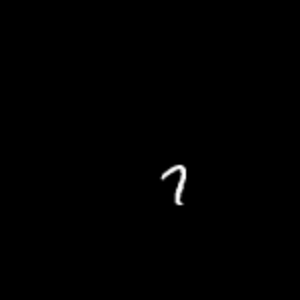

In [0]:
boxTrain = np.random.randint(TARGETSIZE - CURRENTSIZE, size=(x_train.shape[0], 2))
trainInp = np.zeros((x_train.shape[0] , TARGETSIZE,TARGETSIZE, 3) , dtype = np.uint8)

trainTarget = np.zeros((x_train.shape[0] , 10) , dtype=np.float32)
trainTarget[:,0] = y_train[:]
trainTarget[:,1] = boxTrain[: , 0]
trainTarget[:,2] = boxTrain[: , 1]
trainTarget[:,3] = boxTrain[: , 0] + CURRENTSIZE
trainTarget[:,4] = boxTrain[: , 1] + CURRENTSIZE

for i in range(x_train.shape[0]):
  trainInp[i,boxTrain[i,0]:boxTrain[i,0] + CURRENTSIZE ,  boxTrain[i,1]:boxTrain[i,1] + CURRENTSIZE , 0] = cv2.resize(x_train[i,:,:], (CURRENTSIZE,CURRENTSIZE))
  trainInp[i,boxTrain[i,0]:boxTrain[i,0] + CURRENTSIZE ,  boxTrain[i,1]:boxTrain[i,1] + CURRENTSIZE , 1] = cv2.resize(x_train[i,:,:], (CURRENTSIZE,CURRENTSIZE))
  trainInp[i,boxTrain[i,0]:boxTrain[i,0] + CURRENTSIZE ,  boxTrain[i,1]:boxTrain[i,1] + CURRENTSIZE , 2] = cv2.resize(x_train[i,:,:], (CURRENTSIZE,CURRENTSIZE))

  ## bestBox 
  trainTarget[i,5] = bestBoxIndexCalc(trainTarget[i,1:5])
  ## del cx,cy,h,w
  trainTarget[i,6] = (trainTarget[i,3] + trainTarget[i,1])/2.0 -  defaultCentres[trainTarget[i,5].astype(np.int16),0]
  trainTarget[i,7] = (trainTarget[i,2] + trainTarget[i,4])/2.0 -  defaultCentres[trainTarget[i,5].astype(np.int16),1]
  trainTarget[i,8] = CURRENTSIZE -  defaultHW[trainTarget[i,5].astype(np.int16),0]
  trainTarget[i,9] = CURRENTSIZE -  defaultHW[trainTarget[i,5].astype(np.int16),1]


r = random.randint(0,x_train.shape[0])
print(trainTarget[r , :] , defaultBoxes[ trainTarget[r , 5].astype(np.int16) , :])
Image.fromarray(trainInp[r,:,:, :].astype(np.uint8), 'RGB')

[   4.           61.           90.          117.          146.
 1728.           -1.78947368    3.52631579   55.8          55.8       ] [ 60.78947368  84.47368421 120.78947368 144.47368421]


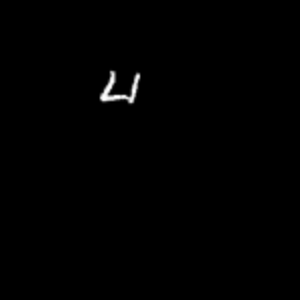

In [0]:
boxTest = np.random.randint(TARGETSIZE - CURRENTSIZE, size=(x_test.shape[0], 2))
testInp = np.zeros((x_test.shape[0] , TARGETSIZE,TARGETSIZE, 3) , dtype = np.uint8)

testTarget = np.zeros((x_test.shape[0] , 10) )
testTarget[:,0] = y_test[:]
testTarget[:,1] = boxTest[: , 0]
testTarget[:,2] = boxTest[: , 1]
testTarget[:,3] = boxTest[: , 0] + CURRENTSIZE
testTarget[:,4] = boxTest[: , 1] + CURRENTSIZE

for i in range(x_test.shape[0]):
  testInp[i,boxTest[i,0]:boxTest[i,0] + CURRENTSIZE ,  boxTest[i,1]:boxTest[i,1] + CURRENTSIZE , 0] = cv2.resize(x_test[i,:,:], (CURRENTSIZE,CURRENTSIZE))
  testInp[i,boxTest[i,0]:boxTest[i,0] + CURRENTSIZE ,  boxTest[i,1]:boxTest[i,1] + CURRENTSIZE , 1] = cv2.resize(x_test[i,:,:], (CURRENTSIZE,CURRENTSIZE))
  testInp[i,boxTest[i,0]:boxTest[i,0] + CURRENTSIZE ,  boxTest[i,1]:boxTest[i,1] + CURRENTSIZE , 2] = cv2.resize(x_test[i,:,:], (CURRENTSIZE,CURRENTSIZE))

  ## bestBox 
  testTarget[i,5] = bestBoxIndexCalc(testTarget[i,1:5])
  ## del cx,cy,h,w
  testTarget[i,6] = (testTarget[i,3] + testTarget[i,1])/2.0 -  defaultCentres[testTarget[i,5].astype(np.int16),0]
  testTarget[i,7] = (testTarget[i,2] + testTarget[i,4])/2.0 -  defaultCentres[testTarget[i,5].astype(np.int16),1]
  testTarget[i,8] = CURRENTSIZE -  defaultHW[testTarget[i,5].astype(np.int16),0]
  testTarget[i,9] = CURRENTSIZE -  defaultHW[testTarget[i,5].astype(np.int16),1]


r = random.randint(0,x_test.shape[0])
print(testTarget[r , :] , defaultBoxes[ testTarget[r , 5].astype(np.int16) , :])
Image.fromarray(testInp[r,:,: , :].astype(np.uint8), 'RGB')


DataSet to pass to model

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainInp, trainTarget))
test_dataset = tf.data.Dataset.from_tensor_slices((testInp, testTarget))

In [0]:
print(train_dataset.element_spec)

(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None))


In [0]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 1000


train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

**LOSS FUNCTION CREATION**

predicted --> n * 8732 * 15

target --> n * 6 [class , BBox , dboxNumber]

In [0]:
def smoothL1(diff):
    L2loss = (diff**2)/2.0
    absLoss = tf.abs(diff) # - 0.5

    return tf.keras.backend.mean(tf.reduce_sum(tf.where(tf.less(absLoss, 1.), L2loss, absLoss-0.5),axis = -1))

In [0]:
def labelLoss(y_pred,trueLabel):
  # pred is n * 10 label is n * 1

  return tf.keras.backend.mean(tf.nn.sparse_softmax_cross_entropy_with_logits( tf.cast( trueLabel, tf.int32) ,y_pred ))

In [0]:
## A very bad implementation , iteration over n 
def LossCreator(batchSize , DEFAULT_BOXES):
  def CustomLoss(y_true , y_pred):
    Loss = 0
    label_batch =  y_true 
    out_batch = y_pred
    for i in range(batchSize):
      bestJ = tf.cast(label_batch[i,5] , tf.int32)
      Loss +=  smoothL1(out_batch[i,bestJ,:4] - label_batch[i,6:])
      trueLabel = tf.cast(label_batch[i,0] , tf.int32)
      labelArray = (tf.zeros((DEFAULT_BOXES,)) + 10 ) + (tf.reshape(tf.one_hot([bestJ], DEFAULT_BOXES), [-1]) * (label_batch[i,0] - 10))
      Loss += labelLoss(out_batch[i,:,4:],labelArray)
    return Loss
  return CustomLoss

In [0]:
# for image_batch, label_batch in train_dataset.take(1):
#    pass

# image_batch.shape ,label_batch.shape

In [0]:
# out_batch = finalModel(image_batch)

In [0]:
# CustomLoss(label_batch,out_batch)

In [0]:
base_learning_rate = 0.001
finalModel.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=LossCreator(BATCH_SIZE , DEFAULT_BOXES))


In [0]:
initial_epochs = 25


In [0]:
history = finalModel.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset)

Epoch 1/25
60/60 [==============================] - 25s 409ms/step - loss: 619.9014 - val_loss: 505.8216
Epoch 2/25
60/60 [==============================] - 16s 275ms/step - loss: 458.3524 - val_loss: 468.8404
Epoch 3/25
60/60 [==============================] - 16s 270ms/step - loss: 406.3410 - val_loss: 385.0652
Epoch 4/25
60/60 [==============================] - 16s 271ms/step - loss: 365.9013 - val_loss: 417.3646
Epoch 5/25
60/60 [==============================] - 16s 274ms/step - loss: 344.0916 - val_loss: 330.9933
Epoch 6/25
60/60 [==============================] - 16s 271ms/step - loss: 326.4107 - val_loss: 361.1674
Epoch 7/25
60/60 [==============================] - 16s 270ms/step - loss: 316.4149 - val_loss: 337.7645
Epoch 8/25
60/60 [==============================] - 16s 271ms/step - loss: 305.1471 - val_loss: 369.0491
Epoch 9/25
60/60 [==============================] - 16s 271ms/step - loss: 295.3419 - val_loss: 318.5701
Epoch 10/25
60/60 [==============================] - 16

ToDo List



*   Inference on test time
*   Visualise data with box

